In [25]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, unix_timestamp, lit, min, max, avg, count
from pyspark.sql.window import Window

# Create a Spark session
spark = SparkSession.builder.appName("LoadAndProcessData").getOrCreate()

# Load the data
df = spark.read.csv('../data/ActionLog2023cleaned', header=True, inferSchema=True)

# Typecast the columns
df = df.withColumn("actiontypecode", col("actiontypecode").cast("int"))

# Identify the escalated cases
escalated_cases_df = df.filter((col('actiontypecode') == 64) | (col('actiontypecode') == 68)).select("casenumber").distinct()
escalated_cases_df = escalated_cases_df.withColumn("escalated", lit(True))

# Delete all following entries after actiontypecode 64 or 68
window_spec = Window.partitionBy("casenumber").orderBy("utcstartdate")
df_with_flag = df.withColumn(
    "delete_flag",
    when((col("actiontypecode") == 64) | (col("actiontypecode") == 68), 1).otherwise(0)
)

# Find the first occurrence of actiontypecode 64 or 68
df_with_flag = df_with_flag.withColumn("first_occurrence", min("delete_flag").over(window_spec))

# Filter out all entries with delete_flag = 1 and first_occurrence = 0
df_filtered = df_with_flag.filter((col("delete_flag") == 0) | (col("first_occurrence") == 0))

# Creating a pivot table with the count of each actiontypecode
pivot_df = df_filtered.groupBy("casenumber").pivot("actiontypecode").count().na.fill(0)

# Create DataFrame with the summary of the cases
case_summary_df = (
    df_filtered.groupBy("casenumber")
    .agg(
        avg("duration").alias("avg_duration"),
        max("actioncreatororganisation").alias("actioncreatororganisation"),
        max("actioncreatordepartment").alias("actioncreatordepartment"),
        max("actioneditordepartment").alias("last_actioneditordepartment"),
        max("actioneditororganisation").alias("last_actioneditororganisation")
    )
    .join(pivot_df, "casenumber", "left")
    .join(escalated_cases_df, "casenumber", "left")
    .na.fill({"escalated": False})
)

case_summary_df.show()

# Save the DataFrames to CSV files
escalated_cases_df.write.csv('../data/EscalatedCases.csv', header=True, mode='overwrite')

# Save the DataFrames to CSV files
case_summary_df.write.csv('../data/CaseSummary.csv', header=True, mode='overwrite')


24/11/03 20:22:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/03 20:22:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/03 20:22:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+----------+--------------------+-------------------------+-----------------------+---------------------------+-----------------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|casenumber|        avg_duration|actioncreatororganisation|actioncreatordepartment|last_actioneditordepartment|last_actioneditororganisation|  5| 10| 11| 15| 20| 21| 22| 40| 41| 46| 47| 48| 49| 50| 51| 55| 62| 64| 65| 66| 67| 68| 69| 70| 76| 77| 82| 83| 85| 87| 90| 91| 92| 95| 96| 97|121|123|130|132|133|134|135|136|137|202|203|204|302|303|304|305|306|307|311|312|313|314|340|341|350|351|400|401|402|403|404|405|406|407|408|409|410|411|412|420|552

24/11/03 20:22:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/03 20:22:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/03 20:22:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


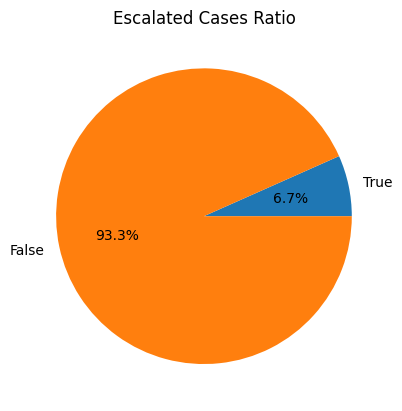

In [24]:
import matplotlib.pyplot as plt

# Calculate the ratio of True to False in the "escalated" column
escalated_ratio = case_summary_df.groupby("escalated").count()
escalated_ratio = escalated_ratio.withColumn("ratio", col("count") / case_summary_df.count()).toPandas()

# Create a pie chart
plt.pie(escalated_ratio["ratio"], labels=escalated_ratio["escalated"], autopct='%1.1f%%')
plt.title("Escalated Cases Ratio")
plt.show()